In [12]:
import tensorflow as tf


physical_devices = tf.config.list_physical_devices("GPU")
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [10]:
#!pip install numba
from numba import cuda

cuda.select_device(0)
cuda.close()

https://www.learndatasci.com/tutorials/hands-on-transfer-learning-keras/#:~:text=In%20the%202014%20ImageNet%20Classification,present%20in%20our%20Food%20dataset.

In [1]:
import os
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np
import datetime
import time
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [2]:
BATCH_SIZE = 64

train_generator =ImageDataGenerator( validation_split=0.15,
                                     preprocessing_function=preprocess_input) # VGG16 preprocessing

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) # VGG16 preprocessing

In [3]:
train_data_dir ='D:/TQ/Fruits360/fruits-360_dataset/fruits-360/Training/'
test_data_dir = 'D:/TQ/Fruits360/fruits-360_dataset/fruits-360/Test/'

total_classes = sorted(os.listdir(train_data_dir))
print(total_classes)


['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Pink Lady', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Corn Husk', 'Cucumber Ripe', 'Cucumber Ripe 2', 'Dates', 'Eggplant', 'Fig', 'Ginger Root', 'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3', 'Grape White 4', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Mango Red', 'Mangostan', 'Maracuja', 'Melo

In [14]:
traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(100, 100),
                                               class_mode='categorical',
                                               classes=total_classes,
                                               subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(100, 100),
                                               class_mode='categorical',
                                               classes=total_classes,
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(100, 100),
                                             class_mode=None,
                                             classes=total_classes,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 57612 images belonging to 131 classes.
Found 10080 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


In [15]:
# Model Creation
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Training without Fine Tuning

In [16]:
input_shape = (100,100, 3)
optim_1 = Adam(learning_rate=0.001)
n_classes=len(total_classes)

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 10

# First we'll train the model without Fine-tuning
vgg_model = create_model(input_shape, n_classes, optim_1, fine_tune=0)

In [17]:
from livelossplot.inputs.keras import PlotLossesCallback

plot_loss_1 = PlotLossesCallback()
csv_logger = CSVLogger('D:/TQ/Fruits360/VGG_Model_July_25_20_Epochs.csv', separator=',')

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='D:/TQ/Fruits360/VGG_Model_10_Epochs_July_26.h5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

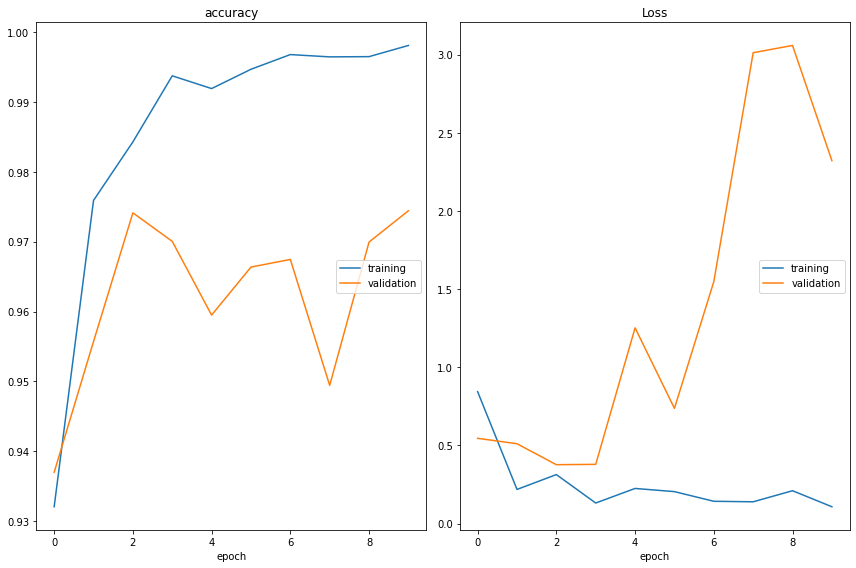

accuracy
	training         	 (min:    0.932, max:    0.998, cur:    0.998)
	validation       	 (min:    0.937, max:    0.974, cur:    0.974)
Loss
	training         	 (min:    0.107, max:    0.843, cur:    0.107)
	validation       	 (min:    0.376, max:    3.059, cur:    2.322)
900/900 [==============================] - 387s 430ms/step - loss: 0.1074 - accuracy: 0.9981 - val_loss: 2.3218 - val_accuracy: 0.9744
CPU times: total: 1h 15min 17s
Wall time: 1h 5min 37s


In [18]:
%%time 

vgg_history = vgg_model.fit(traingen,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=validgen,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
                            verbose=1)

In [19]:
# Generate predictions
vgg_model.load_weights('D:/TQ/Fruits360/VGG_Model_10_Epochs_July_26.h5') # initialize the best trained weights

true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_preds = vgg_model.predict(testgen)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)


22688/22688 [==============================] - 644s 28ms/step


In [20]:
from sklearn.metrics import accuracy_score

vgg_acc = accuracy_score(true_classes, vgg_pred_classes)
print("VGG16 Model Accuracy without Fine-Tuning: {:.2f}%".format(vgg_acc * 100))

VGG16 Model Accuracy without Fine-Tuning: 94.03%


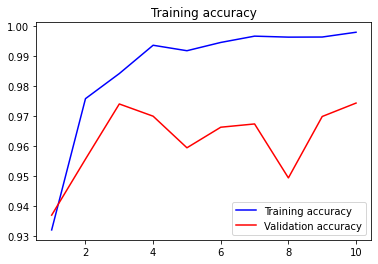

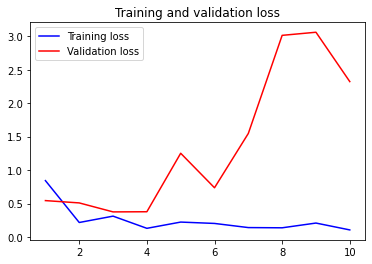

In [24]:
import matplotlib.pyplot as plt
acc = vgg_history.history['accuracy']
val_acc = vgg_history.history['val_accuracy']
loss = vgg_history.history['loss']
val_loss = vgg_history.history['val_loss']
epochs = range(1,len(acc)+1)
plt.figure()
plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training accuracy')
plt.legend()
plt.savefig('D:/TQ/Fruits360/Results/MobileNet_50_Epochs_Accuracy.jpg')
plt.figure()
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('D:/TQ/Fruits360/Results/MobileNet_50_Epochs_Loss.jpg')

In [21]:
# Confusion Matrix
start = datetime.datetime.now()
Y_pred = vgg_preds
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(testgen.classes, y_pred)
print(cm)

end= datetime.datetime.now()
print("Testing End at: ", end)
elapsed= end-start
print ("Time: ", elapsed)

[[ 96   0   0 ...   0   0   0]
 [  0  76   0 ...   0   0   0]
 [  0   0 159 ...   0   0   0]
 ...
 [  0   0   0 ... 158   0   0]
 [  0   0   0 ...   0 249   0]
 [  0   0   0 ...   0   0 157]]
Testing End at:  2022-07-26 14:09:28.671492
Time:  0:00:00.002028


In [22]:
report = classification_report(testgen.classes, y_pred, target_names=total_classes)
print(report)

                     precision    recall  f1-score   support

     Apple Braeburn       0.74      0.59      0.66       164
 Apple Crimson Snow       0.92      0.51      0.66       148
     Apple Golden 1       0.98      0.99      0.98       160
     Apple Golden 2       0.99      1.00      0.99       164
     Apple Golden 3       0.60      0.98      0.75       161
 Apple Granny Smith       1.00      0.60      0.75       164
    Apple Pink Lady       0.64      0.94      0.76       152
        Apple Red 1       0.86      1.00      0.93       164
        Apple Red 2       0.94      0.80      0.86       164
        Apple Red 3       0.99      0.67      0.80       144
Apple Red Delicious       1.00      1.00      1.00       166
 Apple Red Yellow 1       1.00      0.84      0.91       164
 Apple Red Yellow 2       1.00      1.00      1.00       219
            Apricot       1.00      1.00      1.00       164
            Avocado       1.00      0.98      0.99       143
       Avocado ripe    

#Training with Fine Tuning

In [9]:
# Reset our image data generators
traingen.reset()
validgen.reset()
testgen.reset()

# Use a smaller learning rate
optim_2 = Adam(lr=0.0001)

# Re-compile the model, this time leaving the last 2 layers unfrozen for Fine-Tuning
vgg_model_ft = create_model(input_shape, n_classes, optim_2, fine_tune=2)

C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


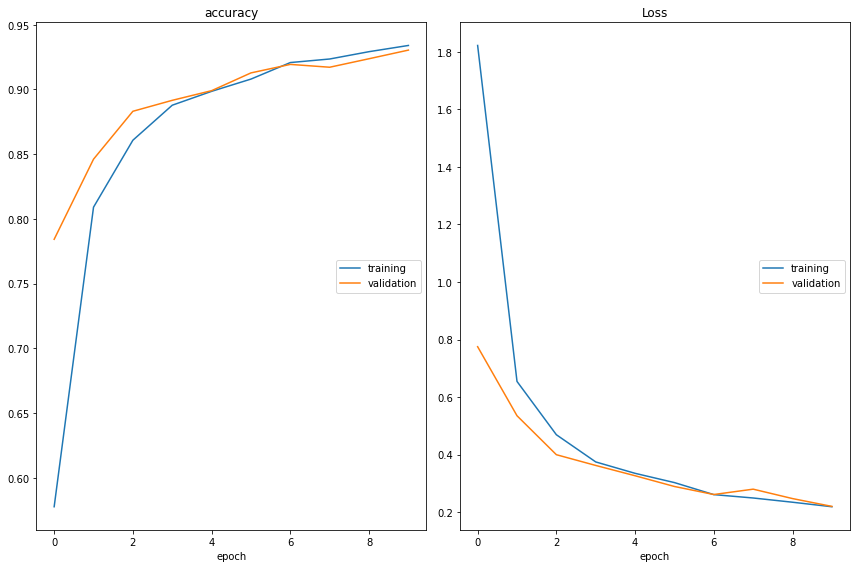

accuracy
	training         	 (min:    0.578, max:    0.934, cur:    0.934)
	validation       	 (min:    0.784, max:    0.930, cur:    0.930)
Loss
	training         	 (min:    0.219, max:    1.822, cur:    0.219)
	validation       	 (min:    0.220, max:    0.775, cur:    0.220)
900/900 [==============================] - 357s 396ms/step - loss: 0.2191 - accuracy: 0.9340 - val_loss: 0.2203 - val_accuracy: 0.9304
CPU times: total: 2h 3min 24s
Wall time: 1h 17min 49s


In [10]:
%%time

plot_loss_2 = PlotLossesCallback()

# Retrain model with fine-tuning
vgg_ft_history = vgg_model_ft.fit(traingen,
                                  batch_size=BATCH_SIZE,
                                  epochs=n_epochs,
                                  validation_data=validgen,
                                  steps_per_epoch=n_steps, 
                                  validation_steps=n_val_steps,
                                  callbacks=[tl_checkpoint_1, early_stop, plot_loss_2],
                                  verbose=1)

In [147]:
vgg_model_ft.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0   

In [11]:
# Generate predictions
#vgg_model_ft.load_weights('tl_model_v1.weights.best.hdf5') # initialize the best trained weights

vgg_preds_ft = vgg_model_ft.predict(testgen)
vgg_pred_classes_ft = np.argmax(vgg_preds_ft, axis=1)

22688/22688 [==============================] - 705s 31ms/step


In [13]:
true_classes = testgen.classes

vgg_acc_ft = accuracy_score(true_classes, vgg_pred_classes_ft)
print("VGG16 Model Accuracy with Fine-Tuning: {:.2f}%".format(vgg_acc_ft * 100))

VGG16 Model Accuracy with Fine-Tuning: 93.84%


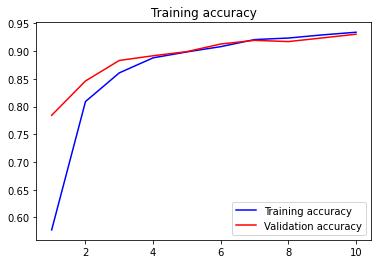

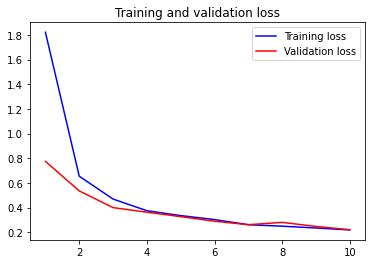

In [17]:
import matplotlib.pyplot as plt

acc = vgg_ft_history.history['accuracy']
val_acc = vgg_ft_history.history['val_accuracy']
loss = vgg_ft_history.history['loss']
val_loss = vgg_ft_history.history['val_loss']
epochs = range(1,len(acc)+1)
plt.figure()
plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training accuracy')
plt.legend()
plt.savefig('D:/TQ/Fruits360/ResNetAccuracy.jpg')
plt.figure()
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('D:/TQ/Fruits360/ResNetLoss.jpg')

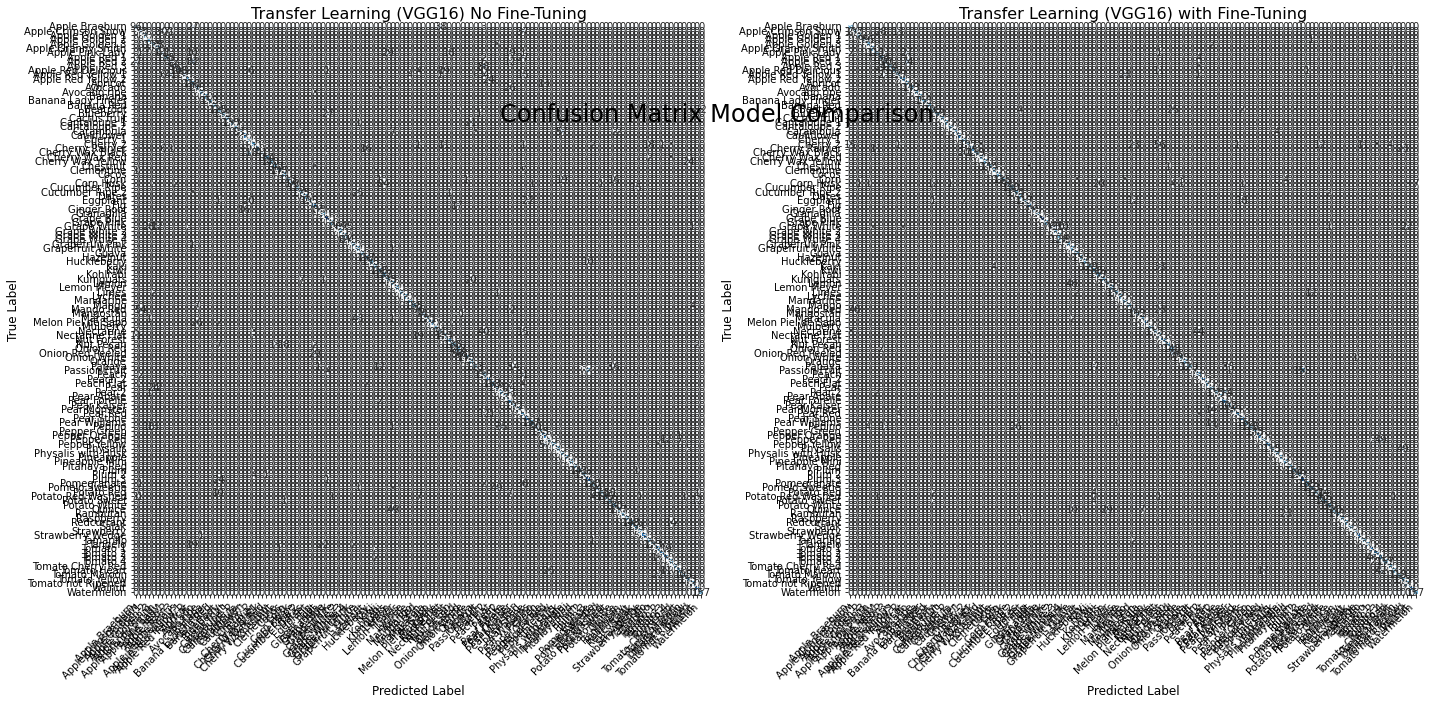

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get the names of the ten classes
class_names = testgen.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, (ax2, ax3) = plt.subplots(1, 2, figsize=(20, 10))


plot_heatmap(true_classes, vgg_pred_classes, class_names, ax2, title="Transfer Learning (VGG16) No Fine-Tuning")    
plot_heatmap(true_classes, vgg_pred_classes_ft, class_names, ax3, title="Transfer Learning (VGG16) with Fine-Tuning")    

fig.suptitle("Confusion Matrix Model Comparison", fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()

In [18]:
vgg_model_ft.save('D:/TQ/Fruits360/VGG_Model_Fine_Tuned.h5')

In [17]:
from tensorflow.keras import models
vgg_model = models.load_model('D:/TQ/Fruits360/VGG_Model_Fine_Tuned.h5')

In [18]:
# Confusion Matrix
start = datetime.datetime.now()
Y_pred = vgg_model.predict(testgen)
y_pred = np.argmax(Y_pred, axis=1)


  947/22688 [>.............................] - ETA: 21:19

KeyboardInterrupt: 

In [ ]:
model_pred = Y_pred
pred_classes = np.argmax(model_pred, axis=1)

In [ ]:
true_classes = testgen.classes

model_acc = accuracy_score(true_classes, pred_classes)
print("VGG16 Model Test Accuracy: {:.2f}%".format(model_acc * 100))

In [ ]:
cm = confusion_matrix(testgen.classes, y_pred)
print(cm)

end= datetime.datetime.now()
print("Testing End at: ", end)
elapsed= end-start
print ("Time: ", elapsed)

In [ ]:
report = classification_report(testgen.classes, y_pred, target_names=total_classes)
print(report)

In [ ]:
file_names=testgen.filenames  # save list of test files names to be used later
tlabels=testgen.labels # save test labels to be used later
class_dict=testgen.class_indices
# code below determines test batch size and test steps
# so you go through the test images exactly once
length=len(file_names) # determine number of images
b_max=80 # set maximum batch size you will allow
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=b_max],reverse=True)[0]
test_steps=int(length/BATCH_SIZE)
# make predictions
preds=Y_pred
new_dict={} 
for key in class_dict: # set key in new_dict to value in class_dict and value in new_dict to key in class_dict
    value=class_dict[key]
    new_dict[value]=key
error_list=[] # empty list to store if the prediction was correct or not
true_predictions = {}
false_predictions = {}
error_file_list=[]
a = b = 1
for i, p in enumerate(preds):
    pred_index=np.argmax(p) # get the index that has the highest probability
    if pred_index == tlabels[i]: #correct predictions
      true_predictions[a] = {}
      true_predictions[a]['PredictedClass'] = new_dict[pred_index]
      true_predictions[a]['TrueClass'] = new_dict[tlabels[i]]
      true_predictions[a]['FileName'] = file_names[i]
      true_predictions[a]['Status'] = 'No'
      error_list.append('No')
      a+=1
    else:
      error_list.append('Yes')
      false_predictions[b] = {}
      false_predictions[b]['PredictedClass'] = new_dict[pred_index]
      false_predictions[b]['TrueClass'] = new_dict[tlabels[i]]
      false_predictions[b]['FileName'] = file_names[i]
      false_predictions[b]['Status'] = 'Yes'
      b+=1
      #print(f'    {pred_class:10s}       {true_class:10s}    {file:25s}   {error_status:10s}')  
      
print("Total Images: ",len(error_list))
print("True Predictions: ",len(true_predictions))
print("False Predictions: ",len(false_predictions))

In [ ]:
print("---------------False Predictions---------")
print('PREDICTED CLASS            TRUE CLASS         FILENAME                        STATUS' ) # adjust spacing based on your class names
for i in range(45,78):
  pred_class = false_predictions[i]['PredictedClass']  # find the predicted class based on the index
  true_class = false_predictions[i]['TrueClass'] # use the test label to get the true class of the test file
  file = false_predictions[i]['FileName']
  status = false_predictions[i]['Status']
  print(f'    {pred_class:10s}       {true_class:10s}    {file:25s}   {status:10s}') 

In [ ]:
print("---------------------True Predictions--------------------\n")
print('PREDICTED CLASS            TRUE CLASS         FILENAME                        STATUS' ) # adjust spacing based on your class names
for i in range(1,50):
  pred_class = true_predictions[i]['PredictedClass']  # find the predicted class based on the index
  true_class = true_predictions[i]['TrueClass'] # use the test label to get the true class of the test file
  file = true_predictions[i]['FileName']
  status = true_predictions[i]['Status']
  print(f'    {pred_class:10s}       {true_class:10s}    {file:25s}   {status:10s}') 

In [27]:
import numpy as np
import keras
from keras.applications.imagenet_utils import decode_predictions
import skimage.io 
import skimage.segmentation
import copy
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import warnings

print('Notebook running: keras ', keras.__version__)
np.random.seed(222)

Notebook running: keras  2.9.0


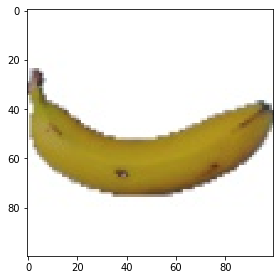

In [158]:
#Xi = skimage.io.imread("D:/TQ/Fruits360/Test_Images/Red_Apple.jpg")

Xi = skimage.io.imread("D:/TQ/Fruits360/fruits-360_dataset/fruits-360/Test/Banana/100_100.jpg")

#Xi = skimage.transform.resize(Xi, (100,100)) 

skimage.io.imshow(Xi) # Show image before inception preprocessing

Xi = preprocess_input(Xi)

In [135]:
import os

def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(100, 100))
        #x = image.img_to_array(img)
        x = np.asarray(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        out.append(x)
    return np.vstack(out)

In [136]:
img_positive = transform_img_fn([os.path.join('D:/TQ/Fruits360/fruits-360_dataset/fruits-360/Test/Apple Braeburn','43_100.jpg')])

plt.imshow(img_positive[0].astype(np.uint8))
preds = vgg_model.predict(img_positive/255)

print(new_dict[np.argmax(preds)])

AttributeError: module 'keras.preprocessing.image' has no attribute 'load_img'

In [134]:
#np.random.seed(222)
#preds = vgg_model.predict(Xi[np.newaxis,:,:,:]/255)


img = image.load_img("D:/TQ/Fruits360/fruits-360_dataset/fruits-360/Test/Apple Braeburn/43_100.jpg",target_size=(100,100))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)


preds = vgg_model.predict(img)
print(preds)
print(total_classes[np.argmax(preds)])


AttributeError: module 'keras.preprocessing.image' has no attribute 'load_img'

In [159]:
preds = vgg_model.predict(Xi[np.newaxis,:,:,:])
print(preds)
print(total_classes[np.argmax(preds)])

1/1 [==============================] - 0s 24ms/step
[[3.28192665e-37 2.09156562e-26 1.52330045e-29 4.77895249e-27
  3.95922115e-25 1.34731210e-28 5.51852656e-29 9.65752981e-30
  6.12444532e-33 2.67495083e-32 2.07511395e-34 3.94718966e-31
  4.82469893e-24 2.45429634e-26 1.08973299e-31 1.19621645e-24
  9.99999523e-01 5.29552608e-07 2.35270664e-17 1.11729812e-27
  1.42536284e-31 1.30983614e-20 1.19564304e-29 1.45351684e-35
  2.03945708e-16 8.96085148e-33 4.78281410e-29 6.29555974e-35
  1.65178969e-26 6.17256790e-35 3.48108678e-30 1.06656450e-27
  1.39054854e-26 1.40446733e-34 1.34347300e-28 8.00908142e-25
  1.45002607e-30 6.00142476e-20 2.32099160e-23 3.73025899e-31
  1.61436566e-23 2.37035784e-29 1.83360605e-30 1.00572567e-24
  1.27870795e-28 8.44476538e-33 2.06762181e-28 5.62120341e-32
  2.13567647e-25 6.93103067e-29 1.63224796e-32 1.93895724e-31
  1.88216526e-30 1.49821178e-25 2.21199705e-29 1.56873586e-32
  2.08349927e-33 1.10995788e-26 6.20334098e-30 4.49747620e-23
  1.29064446e-30 7

In [160]:
top_pred_classes = preds[0].argsort()[-5:][::-1]
top_pred_classes                #Index of top 5 classes

array([16, 17, 24, 18, 37], dtype=int64)

In [161]:
for x in top_pred_classes:
    print(total_classes[x])

Banana
Banana Lady Finger
Carambula
Banana Red
Cucumber Ripe


In [152]:
superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4,max_dist=200, ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0]
num_superpixels

79

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


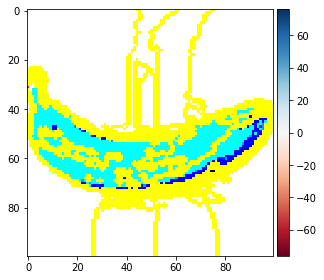

In [153]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi/2+0.5, superpixels))

In [165]:
num_perturb = 150
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
perturbations[0] #Show example of perturbation

array([1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1])

In [172]:
def perturb_image(img,perturbation,segments):
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image

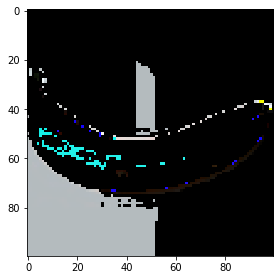

In [173]:
skimage.io.imshow(perturb_image(Xi/2+0.5,perturbations[99],superpixels).astype(np.uint8)*255)

In [174]:
predictions = []
for pert in perturbations:
  perturbed_img = perturb_image(Xi,pert,superpixels)
  pred = vgg_model.predict(perturbed_img[np.newaxis,:,:,:])
  predictions.append(pred)

predictions = np.array(predictions)
predictions.shape

1/1 [==============================] - 0s 45ms/step


(150, 1, 131)

In [175]:
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
distances.shape

(150,)

In [176]:
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
weights.shape

(150,)

In [177]:
class_to_explain = top_pred_classes[0]
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]
coeff

array([ 3.42908309e-02, -1.11597189e-01, -9.72524745e-03,  8.79109548e-02,
       -3.35782556e-02,  3.06364236e-02, -7.06278768e-02,  3.37616409e-03,
        8.02631211e-03, -8.52360598e-02, -4.88350478e-02, -5.82754935e-02,
       -3.41968619e-02,  6.03751963e-02, -5.41583566e-02,  2.33095000e-02,
        1.57968216e-01,  1.37089547e-02, -1.48785814e-03, -6.69266746e-02,
        2.04476746e-02,  7.63824874e-02, -3.32518424e-02, -1.01461854e-01,
        1.17518740e-01,  3.33597649e-04,  2.50718753e-02,  1.25291586e-01,
       -2.12198491e-04,  3.60961594e-02,  1.57368983e-01, -1.37517488e-02,
        5.79132605e-02,  1.23072884e-01, -1.02878375e-02, -2.55501273e-02,
        2.06951592e-02, -1.72275152e-02, -1.67779220e-03, -3.71212024e-02,
        9.79484830e-02, -8.81078793e-03, -1.04478623e-01, -5.85728616e-02,
        2.51585641e-01,  2.26333936e-02,  1.09747411e-01,  2.23159077e-01,
       -1.57798205e-01, -1.24909497e-02,  1.46583607e-03, -8.59400704e-02,
        1.26905391e-01,  

In [178]:
num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:] 
top_features

array([16, 56, 47, 44], dtype=int64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


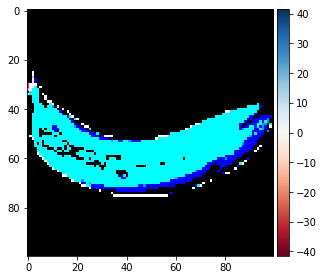

In [179]:
mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi/2+0.5,mask,superpixels) )

# Using LIME

In [58]:
import os
import keras

from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
print('Notebook run using keras:', keras.__version__)

Notebook run using keras: 2.9.0


In [59]:
from tensorflow.keras import models
inet_model  = models.load_model("D:/TQ/Fruits360/VGG_Model_Fine_Tuned.h5")


In [163]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = keras.utils.load_img(img_path, target_size=(100, 100))
        x = keras.utils.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        #x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 49ms/step
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


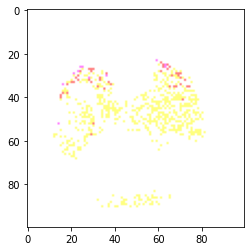

In [164]:
images = transform_img_fn([os.path.join('D:/TQ/Fruits360/Test_Images/','Red_Apple.jpg')])
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(images[0] / 2 + 0.5)
preds = inet_model.predict(images)
for x in preds:
    print(x)